## Environment Setting

In [21]:
import torch
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset, DataLoader, random_split
import os
import pandas as pd
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import random
import torchvision.transforms.functional as TF


## DataLoader

### Load Image

In [ ]:
class MyDataset(Dataset):
    def __init__(self, 
                 root, 
                 if_train = True,
                 data_dir = "train",
                 color_dir = "color",
                 depth_dir = "depth_raw",
                 rgb_name = "rgb.png",
                 depth_name="depth_raw.png",
                 csv_name = "nutrition5k_train.csv",
                 # transform = None, 
                 ):
        self.root = root
        self.data = self.root / data_dir
        self.color_dir  = self.data / color_dir
        self.depth_dir = self.data / depth_dir
        self.rgb_name = rgb_name
        self.depth_name = depth_name
        self.if_train = if_train
        


        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
    

        if self.if_train:
            df = pd.read_csv(self.root / csv_name)
            self.id2cal = {str(r["ID"]) : float(r["Value"]) for _, r in df.iterrows()}

        rgb_paths = sorted((p / rgb_name for p in self.color_dir.glob("dish_*") if (p / rgb_name).exists()))
        if not rgb_paths:
            raise RuntimeError(f"Found 0 images in {self.color_dir}.")
        
        self.samples = []
        if self.if_train:
            for rgb_path in rgb_paths:
                dish_id = rgb_path.parent.name
                if dish_id not in self.id2cal:
                    print(f"Warning: {dish_id} not found in CSV.")
                depth_path = self.depth_dir / dish_id / self.depth_name 
                self.samples.append((rgb_path, depth_path, self.id2cal[dish_id]))
        else:
            for rgb_path in rgb_paths:
                dish_id = rgb_path.parent.name
                depth_path = self.depth_dir / dish_id / self.depth_name 
                self.samples.append((rgb_path, depth_path, None))
                
    def __len__(self):
            return len(self.samples)

    def __getitem__(self, idx):
        try:
            rgb_path, depth_path, cal = self.samples[idx]
            rgb = Image.open(rgb_path).convert("RGB")
            depth = Image.open(depth_path).convert("L")

            # Data enhencement
            if self.if_train:
                # rgb = TF.resize(rgb, (224, 224))
                # depth = TF.resize(depth, (224, 224))

                # 2. RandomRotation
                if random.random() > 0.5:
                    angle = random.uniform(-180, 180)
                    rgb = TF.rotate(rgb, angle, resample=TF.InterpolationMode.BILINEAR)
                    depth = TF.rotate(depth, angle, resample=TF.InterpolationMode.NEAREST)

            else:
                # rgb = TF.resize(rgb, 256)
                # depth = TF.resize(depth, 256)
                # rgb = TF.center_crop(rgb, 224)
                # depth = TF.center_crop(depth, 224)
                pass 
            
            rgb = self.to_tensor(rgb)
            depth = self.to_tensor(depth)
            rgb = self.normalize(rgb)

            if self.if_train:
                cal = torch.tensor(cal, dtype=torch.float32)
                return rgb, depth, cal
            else:
                return rgb, depth

        except (UnidentifiedImageError, FileNotFoundError, Exception) as e:
            print(f"waring: index {idx} sample processing fail, will be taken place by original sample。error: {e}")
            new_idx = random.randint(0, len(self) - 1)
            return self.__getitem__(new_idx)
        

In [23]:
print(Path.cwd())

/kaggle/working


In [ ]:
aiaopath = Path('/kaggle/input/comp-90086-nutrition-5-k/Nutrition5K/Nutrition5K') 
train_set = MyDataset(root=aiaopath, if_train=True) 
test_set = MyDataset(root=aiaopath, data_dir="test", if_train=False) 

dataset_size = len(train_set)
val_ratio = 0.1
val_size = int(dataset_size * val_ratio)
train_size = dataset_size - val_size
train_subset, val_subset = random_split(train_set, [train_size, val_size])

#torch.manual_seed(42) 

train_loader = DataLoader(train_subset, batch_size=8, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False,
                        num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=8, shuffle=False,
                          num_workers=4, pin_memory=True)

# Model Definition

In [ ]:
def conv_block(c_in, c_out, k=3, s=1, p=1, bias=False): 
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, kernel_size=k, stride=s, padding=p, bias=bias),
        nn.BatchNorm2d(c_out),
        nn.ReLU(inplace=True)
    )

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = conv_block(in_channels, out_channels, s=stride)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = self.shortcut(x) 
        out = self.conv1(x)
        out = self.conv2(out)
        out += identity           
        out = self.relu(out)
        return out

class RGBBranch(nn.Module):
    def __init__(self, in_ch=3):
        super().__init__()
        self.stem = nn.Sequential(
            conv_block(in_ch, 32),
            conv_block(32, 32),
            nn.MaxPool2d(2),
            conv_block(32, 64),
            conv_block(64, 64),
            nn.MaxPool2d(2),
            conv_block(64, 128),
            nn.MaxPool2d(2),
            conv_block(128, 256),
            nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem(x)
        x = self.gap(x).flatten(1)
        return x

class DepthBranch(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.stem = nn.Sequential(
            conv_block(in_ch, 16),
            conv_block(16, 16),
            nn.MaxPool2d(2),
            conv_block(16, 32),
            nn.MaxPool2d(2),
            conv_block(32, 64),
            nn.MaxPool2d(2),
            conv_block(64, 128),
            nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem(x)
        x = self.gap(x).flatten(1)
        return x

class RGBDNet(nn.Module):

    def __init__(self, use_dropout=True):
        super().__init__()
        self.rgb = RGBBranch(3)
        self.depth = DepthBranch(1)

        fusion_dim = 256 + 128
        mlp = [
            nn.Linear(fusion_dim, 128),
            nn.ReLU(inplace=True)
        ]
        if use_dropout:
            mlp.append(nn.Dropout(0.1))
        mlp += [
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1)
        ]
        self.head = nn.Sequential(*mlp)

    def forward(self, rgb, depth):
        f_rgb = self.rgb(rgb)       
        f_d   = self.depth(depth)    
        f     = torch.cat([f_rgb, f_d], dim=1)
        out   = self.head(f).squeeze(1)  
        return out



# Training

In [ ]:
if torch.cuda.is_available():
    print(f"detect {torch.cuda.device_count()} GPU avaliable。")
    device = torch.device('cuda')
else:
    print("No GPU detect, runing on cpu")
    device = torch.device('cpu')

model = RGBDNet()  
if torch.cuda.device_count() > 1:
    print("using multipule GPU")
    model = nn.DataParallel(model)

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()


train_losses, val_losses = [], []
train_smapes, val_smapes = [], []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss, smape_sum, n_batches = 0.0, 0.0, 0
    print("Start epoch: " + str(epoch+1))
    image_count = 0

    for rgb, depth, cal in train_loader:
        rgb, depth, cal = rgb.to(device), depth.to(device), cal.to(device)
        pred = model(rgb, depth)
        loss = criterion(pred, cal)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * rgb.size(0)
        smape_batch = torch.mean( 2 * torch.abs(pred - cal) / (torch.abs(pred) + torch.abs(cal) + 1e-8)).item()
        smape_sum += smape_batch
        n_batches += 1

        image_count += rgb.size(0)
        print(f"Processed {image_count} images", end='\r')

    train_loss = running_loss / len(train_loader.dataset)
    train_smape = smape_sum / n_batches
    train_losses.append(train_loss)
    train_smapes.append(train_smape)

    model.eval()
    val_loss, smape_sum, n_batches = 0.0, 0.0, 0
    with torch.no_grad():
        for rgb, depth, cal in val_loader:
            rgb, depth, cal = rgb.to(device), depth.to(device), cal.to(device)
            pred = model(rgb, depth)
            loss = criterion(pred, cal)
            val_loss += loss.item() * rgb.size(0)
            smape_batch = torch.mean( 2 * torch.abs(pred - cal) / (torch.abs(pred) + torch.abs(cal) + 1e-8)).item()
            smape_sum += smape_batch
            n_batches += 1

    val_loss /= len(val_loader.dataset)
    val_smape = smape_sum / n_batches
    val_losses.append(val_loss)
    val_smapes.append(val_smape)

    torch.cuda.empty_cache()

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train SMAPE: {train_smape*100:.3f}%, Val MAPE: {val_smape*100:.3f}%")




检测到 2 张可用的GPU。
正在使用多张GPU进行并行计算...
Start epoch: 1
警告: 索引 2368 的样本损坏或处理失败，将被替换。错误: cannot identify image file '/kaggle/input/comp-90086-nutrition-5-k/Nutrition5K/Nutrition5K/train/depth_raw/dish_2368/depth_raw.png'
Epoch [1/10] | Train Loss: 180.7874, Val Loss: 119.5841, Train SMAPE: 116.789%, Val MAPE: 69.675%
Start epoch: 2
警告: 索引 2368 的样本损坏或处理失败，将被替换。错误: cannot identify image file '/kaggle/input/comp-90086-nutrition-5-k/Nutrition5K/Nutrition5K/train/depth_raw/dish_2368/depth_raw.png'
Epoch [2/10] | Train Loss: 113.2727, Val Loss: 97.6317, Train SMAPE: 64.143%, Val MAPE: 58.346%
Start epoch: 3
警告: 索引 2368 的样本损坏或处理失败，将被替换。错误: cannot identify image file '/kaggle/input/comp-90086-nutrition-5-k/Nutrition5K/Nutrition5K/train/depth_raw/dish_2368/depth_raw.png'
Epoch [3/10] | Train Loss: 103.3941, Val Loss: 114.7930, Train SMAPE: 60.338%, Val MAPE: 68.883%
Start epoch: 4
警告: 索引 2368 的样本损坏或处理失败，将被替换。错误: cannot identify image file '/kaggle/input/comp-90086-nutrition-5-k/Nutrition5K/Nutrition5K/

In [27]:
save_path = "/kaggle/working/my_model_weights.pth" 
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")


Model weights saved to /kaggle/working/my_model_weights.pth


## Plot

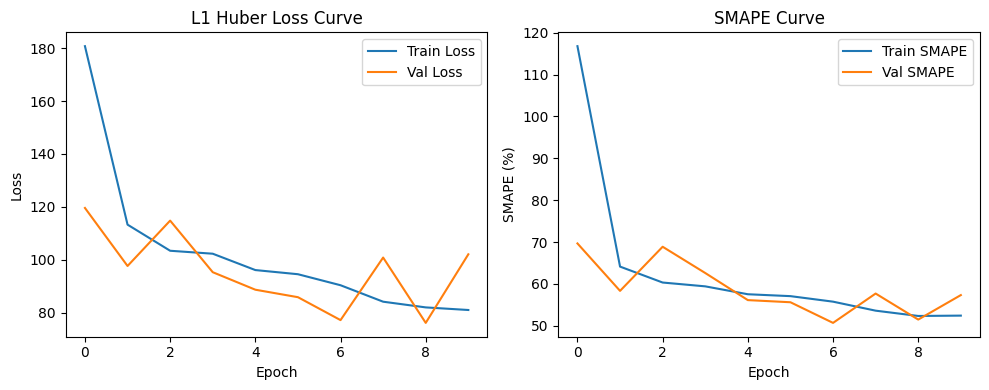

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('L1 Huber Loss Curve'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot([m*100 for m in train_smapes], label='Train SMAPE')
plt.plot([m*100 for m in val_smapes], label='Val SMAPE')
plt.title('SMAPE Curve'); plt.xlabel('Epoch'); plt.ylabel('SMAPE (%)'); plt.legend()

plt.tight_layout()
plt.show()

# Testing

In [29]:
model.eval()
predictions = []
submission_df = pd.DataFrame({"ID": [], "Value": []})
with torch.no_grad():
    for rgb, depth in test_loader:
        rgb, depth = rgb.to(device), depth.to(device)
        pred = model(rgb, depth)
        predictions.extend(pred.cpu().numpy())

submission_df = pd.DataFrame({"ID": [f"dish_{3300+i:04d}" for i in range(1, len(predictions)+1)],
                                    "Value": predictions})


In [30]:
output_filepath = "/kaggle/working/submission.csv"

submission_df.to_csv(output_filepath, index=False)